In [3]:
import os
import warnings
from typing import List

import cv2
import numpy as np
from PIL import Image, ImageFile
from torch.utils.data import Dataset

In [7]:
ROOT = "/Users/hinsun/Workspace/ComputerScience/UNetWithBraTS/data/OxfordIIITPet/oxford-iiit-pet"

if not os.path.exists(ROOT):
    raise FileNotFoundError(f"Dataset root path does not exist: {ROOT}")

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings("ignore", category=UserWarning)


class OxfordIIIPetDataset(Dataset):
    def __init__(
        self,
        root: str,
        is_train: bool = True,
        transform=None,
    ):
        self.root = root
        self.transform = transform
        self.classes = ["background", "animal", "border"]
        self.image_names: List[str] = []

        if is_train:
            annotations = os.path.join(root, "annotations", "trainval.txt")
        else:
            annotations = os.path.join(root, "annotations", "test.txt")

        # Read the annotation file and extract image names
        with open(annotations, "r") as f:
            self.image_names = [image.split(" ")[0] for image in f.readlines()]

        if not self.image_names:
            raise ValueError(f"No images found in the dataset at {annotations}")

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, idx: int):
        try:
            image_name = self.image_names[idx]
            image_path = os.path.join(self.root, "images", image_name + ".jpg")
            mask_path = os.path.join(
                self.root,
                "annotations",
                "trimaps",
                image_name + ".png",
            )

            image_pil = Image.open(image_path).convert("RGB")

            # Convert to numpy array (RGB format)
            image = np.array(image_pil)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Cannot load mask: {mask_path}")

            # Convert mask values from {1,2,3} to {0,1,2}
            mask = mask - 1

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented["image"]
                mask = augmented["mask"]

            return image, mask

        except Exception as exception:
            print(f"Loading exception at index {idx}: {exception}")
            next_idx = (idx + 1) % len(self.image_names)
            return self.__getitem__(next_idx)

In [13]:
train_dataset = OxfordIIIPetDataset(root=ROOT, is_train=True)
test_dataset = OxfordIIIPetDataset(root=ROOT, is_train=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))
print("Classes:", train_dataset.classes)

Number of training samples: 3680
Number of testing samples: 3669
Classes: ['background', 'animal', 'border']


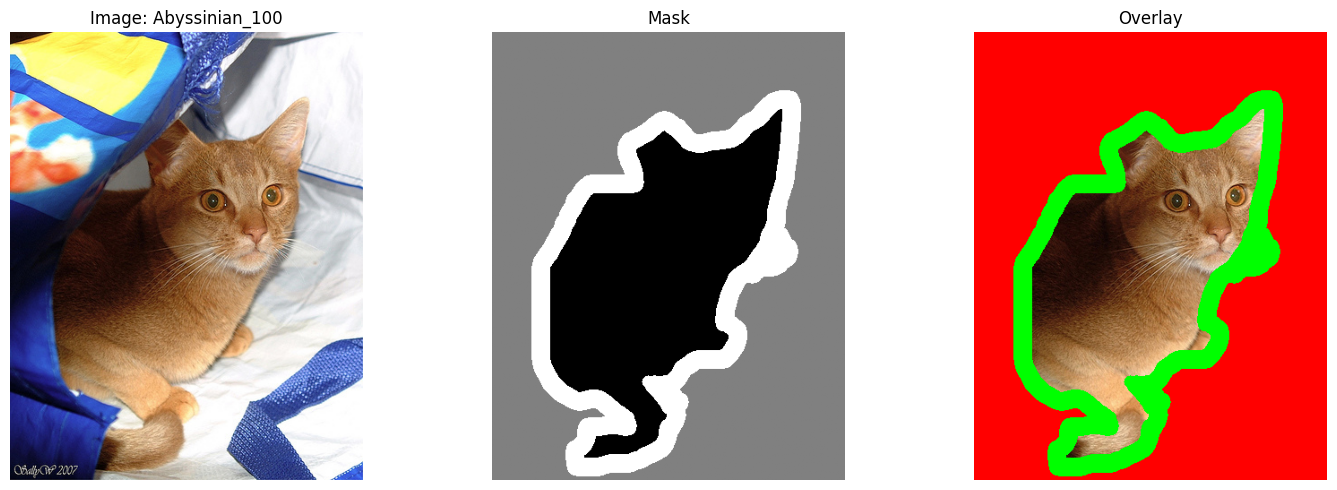

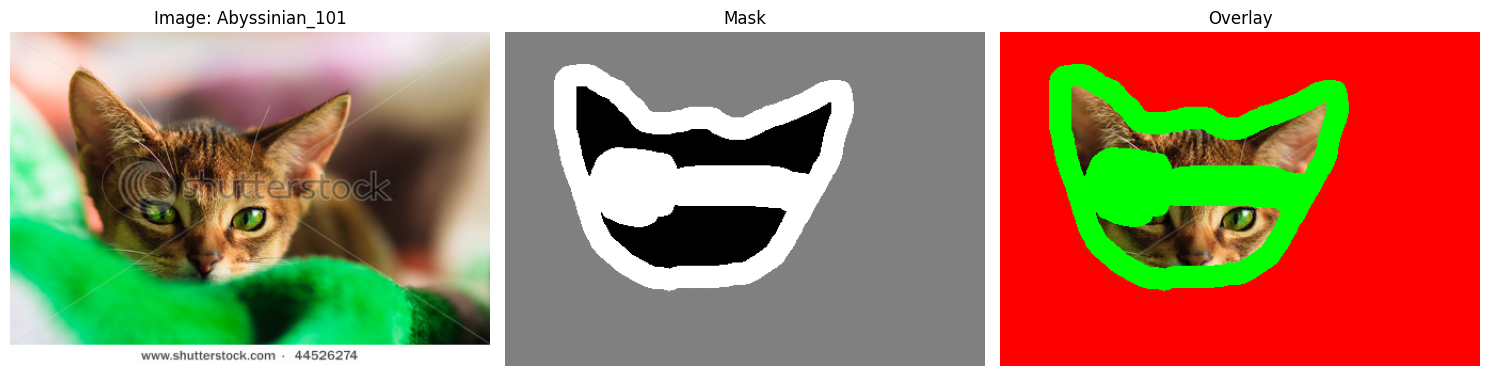

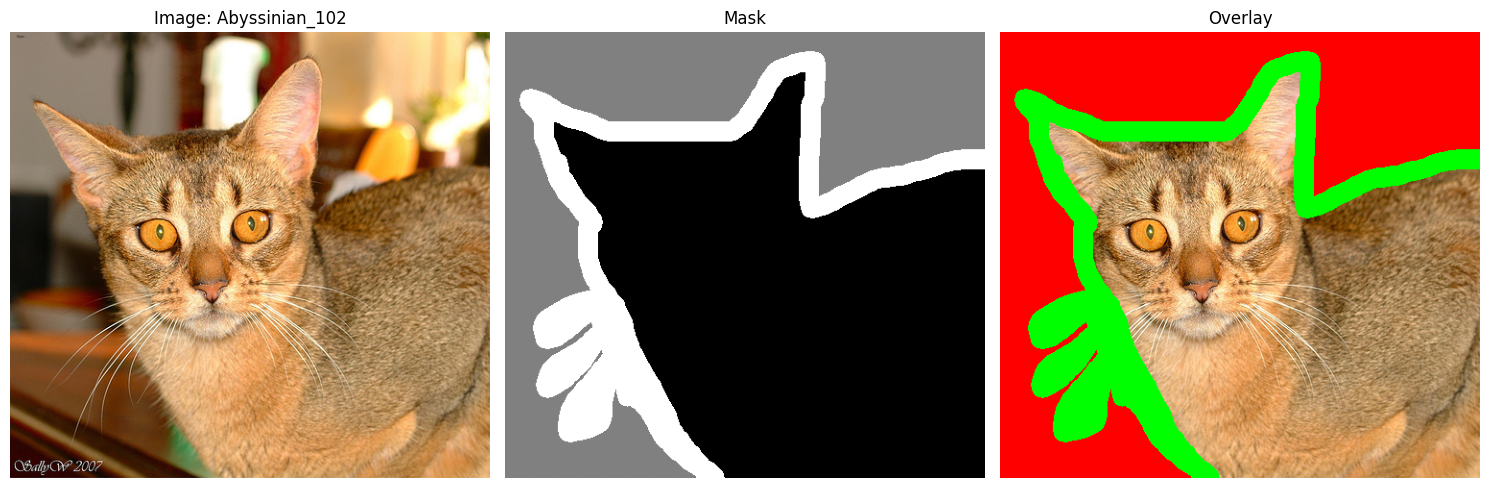

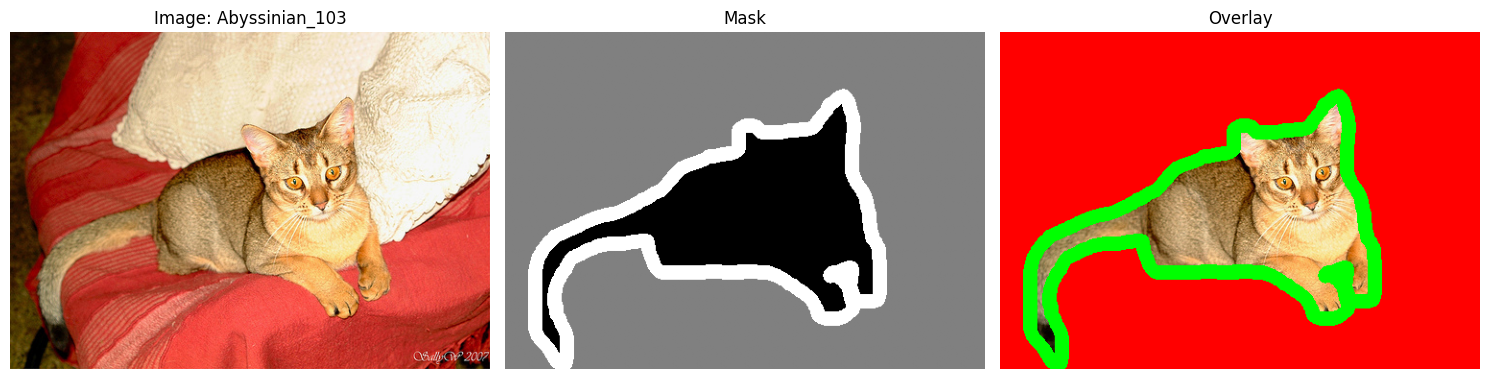

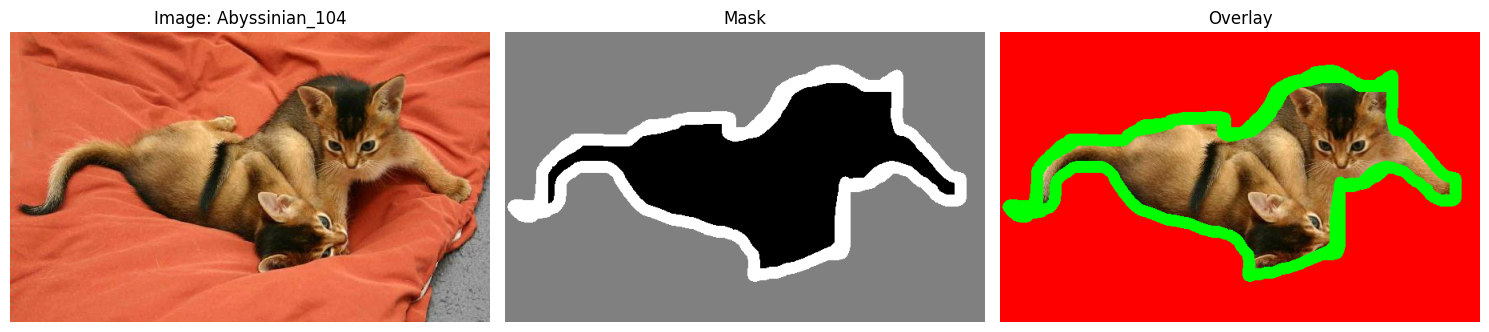

In [15]:
import matplotlib.pyplot as plt


def visualize_sample(dataset, idx):
    image, mask = dataset[idx]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title(f"Image: {dataset.image_names[idx]}")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")

    overlay = image.copy()
    overlay[mask == 1] = [255, 0, 0]
    overlay[mask == 2] = [0, 255, 0]
    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


for i in range(5):
    visualize_sample(train_dataset, i)

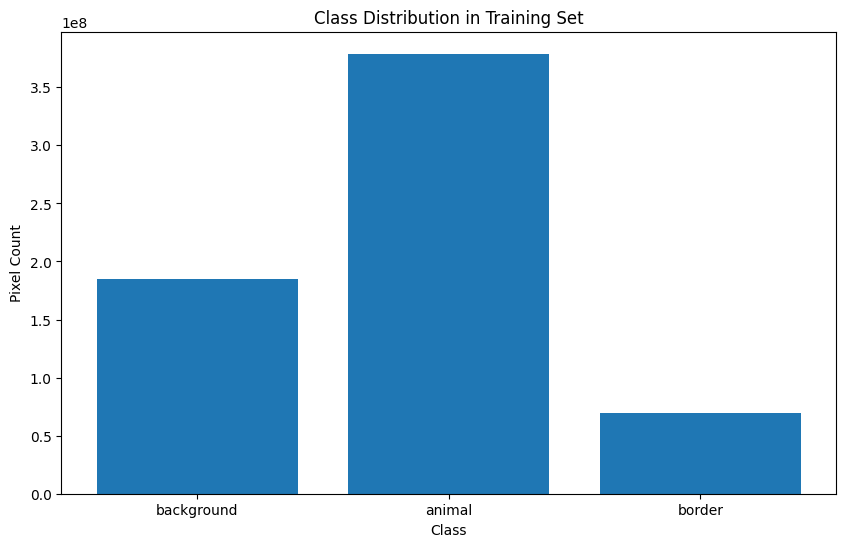

Class distribution:
background: 184,563,866 pixels
animal: 378,924,356 pixels
border: 69,303,313 pixels


In [16]:
class_counts = {0: 0, 1: 0, 2: 0}

for idx in range(len(train_dataset)):
    _, mask = train_dataset[idx]
    unique, counts = np.unique(mask, return_counts=True)
    for cls, count in zip(unique, counts):
        class_counts[cls] += count

# Visualize phân bố
plt.figure(figsize=(10, 6))
plt.bar(train_dataset.classes, class_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.show()

print("Class distribution:")
for cls, count in class_counts.items():
    print(f"{train_dataset.classes[cls]}: {count:,} pixels")

In [17]:
sizes = []
for idx in range(min(100, len(train_dataset))):
    image, _ = train_dataset[idx]
    sizes.append(image.shape[:2])

sizes = np.array(sizes)
print(f"Min size: {sizes.min(axis=0)}")
print(f"Max size: {sizes.max(axis=0)}")
print(f"Mean size: {sizes.mean(axis=0).astype(int)}")

Min size: [233 192]
Max size: [1200 1600]
Mean size: [426 458]
